<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/InverseLinkPredcition/blob/main/Sparcification_GCN_Comparison_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/MOF/InverseLinkPredcition')

Mounted at /content/drive


In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 30.9 MB/s eta 0:00:00


Unique node labels: 6514
Filtered summary data:
 6514


<ipython-input-10-872d998bfb34>:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_data_filtered['PLD_category'] = pd.cut(


Epoch 1/500
128/131 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3450 - loss: 1.8869
Epoch 1: val_accuracy improved from -inf to 0.63854, saving model to best_gcn_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3466 - loss: 1.8795 - val_accuracy: 0.6385 - val_loss: 1.2516
Epoch 2/500
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5123 - loss: 1.2758
Epoch 2: val_accuracy improved from 0.63854 to 0.70374, saving model to best_gcn_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5128 - loss: 1.2745 - val_accuracy: 0.7037 - val_loss: 0.9396
Epoch 3/500
129/131 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6207 - loss: 1.0428
Epoch 3: val_accuracy did not improve from 0.70374
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6209 - loss: 1.0425 - val_accuracy: 0.6922 - val_loss: 0.8714
Epoch 4/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6631 - loss: 0.9342
Epoch 4: val_accuracy improved from 0.70374 to 0.71333, savi

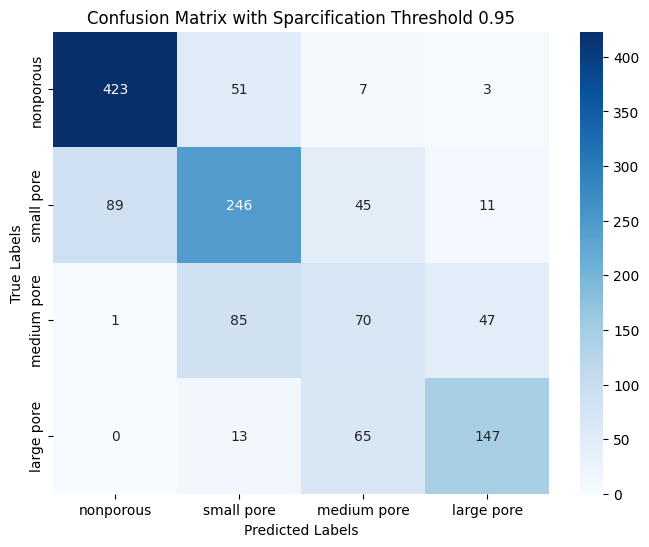

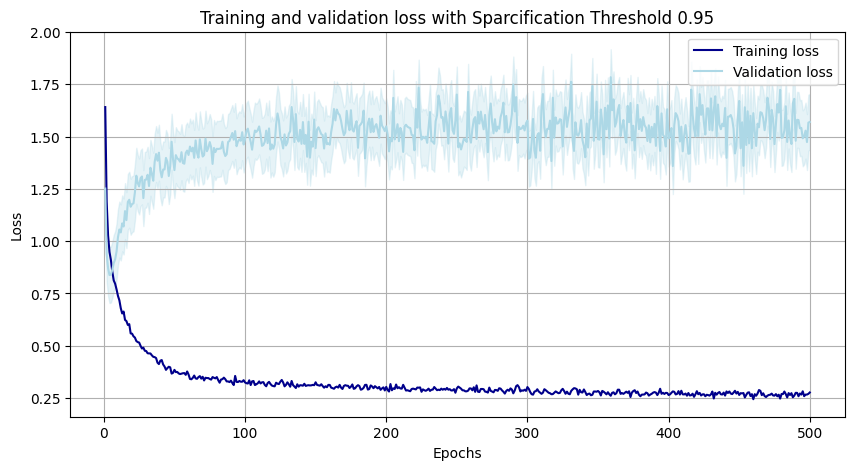

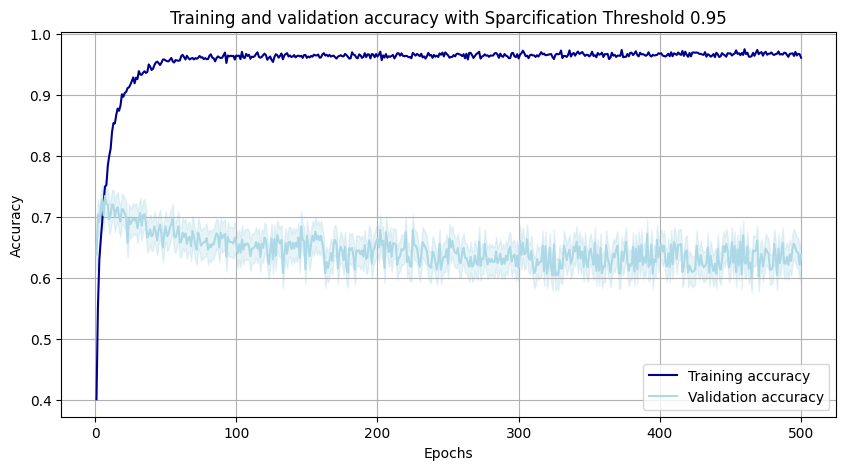

Test Accuracy with KNN and Sparcification Threshold 0.95: 0.7697620874904068
Number of samples in the testing set: 1303


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import tensorflow as tf
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers, regularizers



np.random.seed(56)
random.seed(56)
tf.random.set_seed

def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

import numpy as np
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    # Extract loss and accuracy from history
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)
    accuracy = history.history['accuracy']
    val_accuracy = history.history.get('val_accuracy', None)
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'darkblue', label='Training loss')  # Change color to dark blue
    if val_loss:
        plt.plot(epochs, val_loss, 'lightblue', label='Validation loss')  # Change color to light blue
        plt.fill_between(epochs, np.array(val_loss) - np.std(val_loss), np.array(val_loss) + np.std(val_loss), color='lightblue', alpha=0.3)  # Fill between mean - std and mean + std
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, accuracy, 'darkblue', label='Training accuracy')  # Change color to dark blue
    if val_accuracy:
        plt.plot(epochs, val_accuracy, 'lightblue', label='Validation accuracy')  # Change color to light blue
        plt.fill_between(epochs, np.array(val_accuracy) - np.std(val_accuracy), np.array(val_accuracy) + np.std(val_accuracy), color='lightblue', alpha=0.3)  # Fill between mean - std and mean + std
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()



# Function to train and evaluate different classifiers
def train_and_evaluate_classifier(classifier, train_features, train_labels, test_features, test_labels):
    classifier.fit(train_features, train_labels)
    accuracy = classifier.score(test_features, test_labels)
    return accuracy




def preprocess_graph(graph, features):
    # Determine the dimensionality of the feature vectors
    feature_dimension = features.shape[1]

    # Convert the graph to an adjacency matrix
    adjacency_matrix = nx.adjacency_matrix(graph).toarray()

    # Initialize an empty list to store feature vectors
    feature_vectors = []

    # Create a mapping from node labels to integer indices
    node_to_index = {node: index for index, node in enumerate(graph.nodes())}

    # Iterate over nodes in the graph
    for node in graph.nodes():
        # Get the integer index corresponding to the node label
        node_index = node_to_index[node]
        # Check if the node index is valid
        if node_index < len(features):
            # Append the feature vector corresponding to the node index
            feature_vectors.append(features[node_index])
        else:
            # If the node index is out of range, assign a default feature vector
            feature_vectors.append(np.zeros((feature_dimension,)))

    # Convert the list of feature vectors to a numpy array
    feature_matrix = np.array(feature_vectors)

    return adjacency_matrix, feature_matrix


def build_gcn_model(input_shape_feature, input_shape_adjacency, num_classes):
    # Define input layers
    x_inp_feature = Input(shape=(input_shape_feature,))
    x_inp_adjacency = Input(shape=(input_shape_adjacency,))

    # Define GCN layers for feature input
    x_feature = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x_inp_feature)
    x_feature = Dropout(0.5)(x_feature)
    x_feature = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x_feature)
    x_feature = Dropout(0.5)(x_feature)

    # Define GCN layers for adjacency input
    x_adjacency = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x_inp_adjacency)
    x_adjacency = Dropout(0.5)(x_adjacency)
    x_adjacency = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x_adjacency)
    x_adjacency = Dropout(0.5)(x_adjacency)

    # Concatenate feature and adjacency outputs
    x = concatenate([x_feature, x_adjacency])

    # Adding more hidden layers for better representation learning
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)

    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=[x_inp_feature, x_inp_adjacency], outputs=output)

    # Using a smaller learning rate
    optimizer = Adam(learning_rate=0.001)

    # Compile model
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

    return model

def build_feedforward_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



def train_gcn_model(model, adjacency_matrix, feature_matrix, labels, epochs, batch_size):
    if model is not None and adjacency_matrix is not None and feature_matrix is not None and labels is not None:

        history=model.fit([feature_matrix, adjacency_matrix], labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)
        return history
    else:
        print("Error: One or more input arguments to train_gcn_model is None.")
def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])


def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros((1024,), dtype=float)  # Return an array of zeros if molecule can't be parsed
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024), dtype=float)
    except Exception as e:
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,), dtype=float)  # Return an array of zeros in case of an error


if __name__ == "__main__":
    # Define the filenames
    # edges_list_filename = 'edges_list_0.8_Full.csv' , edges_list_filename ='sparsified_graph_edges_0.98.csv'
    edges_list_filename ='sparsified_graph_edges_0.98.csv'
    summary_data_filename = '1M1L3D_summary.csv'

    # Load the edge list from the CSV file
    edges_list = pd.read_csv(edges_list_filename, header=None, names=['source', 'target', 'weight'], delimiter=' ')

    # Extract unique node labels from the edge list
  # Load summary data
    summary_data = pd.read_csv(summary_data_filename)

    node_labels_source = edges_list['source'].astype(str).unique()

    node_labels_target = edges_list['target'].astype(str).unique()

    node_labels = np.concatenate((node_labels_source, node_labels_target))
    node_labels = np.unique(node_labels)





    # Remove any duplicate labels
    node_labels = list(set(node_labels))

    # Debug print statement
    print("Unique node labels:", len(node_labels))


    # Filter summary data based on node labels
    summary_data_filtered = summary_data[summary_data['refcode'].isin(node_labels)]  # Replace '<column_name>' with the actual column name containing node labels

       # Debug print statement to check contents of filtered summary data
    print("Filtered summary data:\n", len(summary_data_filtered))

    # Extract features and labels
    if not summary_data_filtered.empty:
        linker_smiles = summary_data_filtered['linker SMILES']
        if not linker_smiles.empty:
            linker_features = np.stack(linker_smiles.dropna().apply(generate_fingerprint).values)
            metal_names = summary_data_filtered['metal']
            metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)
            other_features = summary_data_filtered[['Largest Cavity Diameter', 'Largest Free Sphere']].values.astype(
                'float32')
            features = np.concatenate((linker_features, metal_features, other_features), axis=1)
            summary_data_filtered['PLD_category'] = pd.cut(summary_data_filtered['Pore Limiting Diameter'], bins=[-np.inf, 2.4, 4.4, 5.9, np.inf], labels=['nonporous', 'small pore', 'medium pore', 'large pore'])
            labels = pd.get_dummies(summary_data_filtered['PLD_category']).values
            print ('Number of Labels', len(labels))
            # Load the sparsified graph
            graph = nx.read_weighted_edgelist(edges_list_filename)

            # Print the number of nodes and edges in the graph
            print("Number of nodes:", graph.number_of_nodes())
            print("Number of edges:", graph.number_of_edges())

            # Preprocess the graph data
            adjacency_matrix, feature_matrix = preprocess_graph(graph, features)

          # Provide the number of classes
            num_classes = labels.shape[1]

            # Build the GCN model
            gcn_model = build_gcn_model(feature_matrix.shape[1], adjacency_matrix.shape[1], num_classes)


            # Train the GCN model
            history=train_gcn_model(gcn_model, adjacency_matrix, feature_matrix, labels, epochs=40, batch_size=32)
            # Save the trained GCN model
            gcn_model.save("gcn_model_0.98.h5")

            # Save the adjacency matrix
            np.save("adjacency_matrix_0.98.npy", adjacency_matrix)
            # Calculate accuracy
            test_loss, test_accuracy = gcn_model.evaluate([feature_matrix, adjacency_matrix], labels, verbose=0)
            print(f'Test Accuracy: {test_accuracy}')

            # Plot loss and accuracy
            plot_loss_accuracy(history)
            y_true = np.argmax(labels, axis=1)  # Convert one-hot encoded labels to integer labels
            y_pred = np.argmax(gcn_model.predict([feature_matrix, adjacency_matrix]), axis=1)  # Get predicted labels
            classes = ['nonporous', 'small pore', 'medium pore', 'large pore']  # List of class labels
            plot_confusion_matrix(y_true, y_pred, classes)



            # Split data into training and testing sets
            train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)
            # Train and evaluate Gradient Boosted Trees


        else:
            print("Error: linker_smiles column is empty.")
    else:
        print("Error: summary_data_filtered DataFrame is empty.")
